In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Location of dataset on machine
# personal_file_base = "C:/Users/laela/large_datasets/CSE 543 Dataset/"

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
# # Create dataframe from CSV files

# # Load the CSV file into a pandas DataFrame
# shared_file_base = "MachineLearningCSV/MachineLearningCVE/"
# all_df_paths = ["Monday-WorkingHours.pcap_ISCX.csv", "Tuesday-WorkingHours.pcap_ISCX.csv", "Wednesday-workingHours.pcap_ISCX.csv", "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv","Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv", "Friday-WorkingHours-Morning.pcap_ISCX.csv", "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"]
# df_paths = ["Wednesday-workingHours.pcap_ISCX.csv", "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"]
# df = pd.DataFrame()
# for df_path in df_paths:
#     day_df = pd.read_csv(df_path)
#     df = pd.concat([df, day_df], ignore_index=True)
# print("Dataframe is of shape", df.shape)

In [ ]:
# # Dataframe preprocessing

# # Removes unnecessary white space from column names
# df.columns = df.columns.str.strip()

# features_all_0 = ["Bwd PSH Flags", "Fwd URG Flags", "Bwd URG Flags", "CWE Flag Count", "Fwd Avg Bytes/Bulk", "Fwd Avg Packets/Bulk", "Fwd Avg Bulk Rate", "Bwd Avg Bytes/Bulk", "Bwd Avg Packets/Bulk", "Bwd Avg Bulk Rate"]
# features_dervived = ['Flow Bytes/s', 'Flow Packets/s', 'Fwd Packets/s', 'Bwd Packets/s']
# features_categorical = ['Label']
# #features_negative_values = ['Flow Duration', 'Flow IAT Mean', 'Flow IAT Max', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward']
# #features_large_negative_values = ['Flow IAT Min', 'Fwd IAT Min', 'Fwd Header Length', 'Fwd Header Length.1']

# # Removes some features
# df_feature_selection = df.drop(columns=features_all_0, axis=1)
# df_feature_selection = df_feature_selection.drop(columns=features_dervived, axis=1)

# # Remove samples with invalid features (about half of samples)
# df_feature_selection = df_feature_selection.replace(range(-14, 0), np.nan).dropna()

# # Converts categorical data into numerical data
# feature_mappings = {}
# for feature in features_categorical:
#     label_encoder = LabelEncoder()
#     df_feature_selection[feature] = label_encoder.fit_transform(df_feature_selection[feature])
#     mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
#     print(f"Mapping for feature '{feature}': {mapping}") # 'BENIGN': 440031+97718=537749, 'DDoS': 128027, 'DoS GoldenEye': 10293, 'DoS Hulk': 231973, 'DoS Slowhttptest': 5499, 'DoS slowloris': 5796, 'Heartbleed': 11
#     for index, value in mapping.items():
#         feature_mappings[value] = index
# # Converts port numbers from categorical to numerical
# def replace_port_numbers(x):
#     return 1 if x == 80 else 0
# df_feature_selection['Destination Port'] = df_feature_selection['Destination Port'].apply(replace_port_numbers)

# print(df_feature_selection.shape)
# X = df_feature_selection.drop(['Label'], axis=1)
# y = df_feature_selection['Label']

# # Compute the correlation of each feature with the target
# correlations = abs(X.corrwith(pd.Series(y)))

# # Display the correlations
# pd.set_option('display.max_rows', None) # Display all rows
# correlations = correlations.sort_values(ascending=False)

# X = X.drop(correlations.index[25:], axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Begining of data preprocessing code added by Ahmad
df1 = pd.read_csv('/content/drive/MyDrive/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2 = pd.read_csv("/content/drive/MyDrive/Wednesday-workingHours.pcap_ISCX.csv")
df = pd.concat([df1, df2], axis=0)

df.columns = df.columns.str.strip() # Removes unnecessary white space from column names

label = {   # Labelling the target variable with numeric values
    'BENIGN': 0,
    'DDoS': 1,
    'DoS slowloris': 1,
    'DoS Slowhttptest': 1,
    'DoS Hulk': 1,
    'DoS GoldenEye': 1,
    'Heartbleed': 2
}

df['Label'] = df['Label'].map(label) # mapping the labels to their numeric values in df

df = df.dropna() # Removing rows that contain NaN values in df
df = df[~df.isin([np.inf, -np.inf]).any(axis=1)] # Removing rows that contain inf values in df
df = df.loc[:, (df != 0).any(axis=0)] # Removing columns that only contain 0s in df
df.drop(df[df['Label'] == 2].index, inplace = True) # Removing the Heartbleed data (only 11 present)

def replace_port_numbers(x):
     return 1 if x == 80 else 0

df['Destination Port'] = df['Destination Port'].apply(replace_port_numbers)

X = df.drop(columns=['Label'])
y = df['Label']

correlations = abs(X.corrwith(pd.Series(y)))
correlations = correlations.sort_values(ascending=False)
X = X.drop(correlations.index[25:], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# End of data preprocessing code added by Ahmad

In [ ]:
best_k = 1

In [ ]:
from tqdm import tqdm
# Find best value of k using 5-fold cross-validation
from sklearn.model_selection import cross_val_score

# Create a range of k values to test

k_values = np.arange(1, 15, 2) # Range of number of neighbors
mean_scores = []

for k in tqdm(k_values):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy', verbose=2) # 5-fold cross-validation (31 minutes)
    mean_scores.append(scores.mean())
    print(scores, len(scores))
    print(mean_scores)
best_k = k_values[np.argmax(mean_scores)]
print(f'Best k: {best_k}')

  0%|          | 0/7 [00:00<?, ?it/s]

[CV] END .................................................... total time=13.5min
[CV] END .................................................... total time=13.5min
[CV] END .................................................... total time=13.5min
[CV] END .................................................... total time=13.4min


 14%|█▍        | 1/7 [1:07:12<6:43:16, 4032.73s/it]

[CV] END .................................................... total time=13.3min
[0.99516148 0.99535229 0.99513422 0.995325   0.99515463] 5
[0.9952255235208505]
[CV] END .................................................... total time=13.3min


In [ ]:
# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=1)  # You can adjust the number of neighbors (k)
knn.fit(X_train, y_train)
classes = knn.classes_

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Output predictions
print(f'Predictions: {y_pred}')

Accuracy: 0.9936515329472277
Precision: 0.9936605059833867
Recall: 0.9936515329472277
F1 Score: 0.9936537787733184
Predictions: [0 0 0 ... 3 0 1]


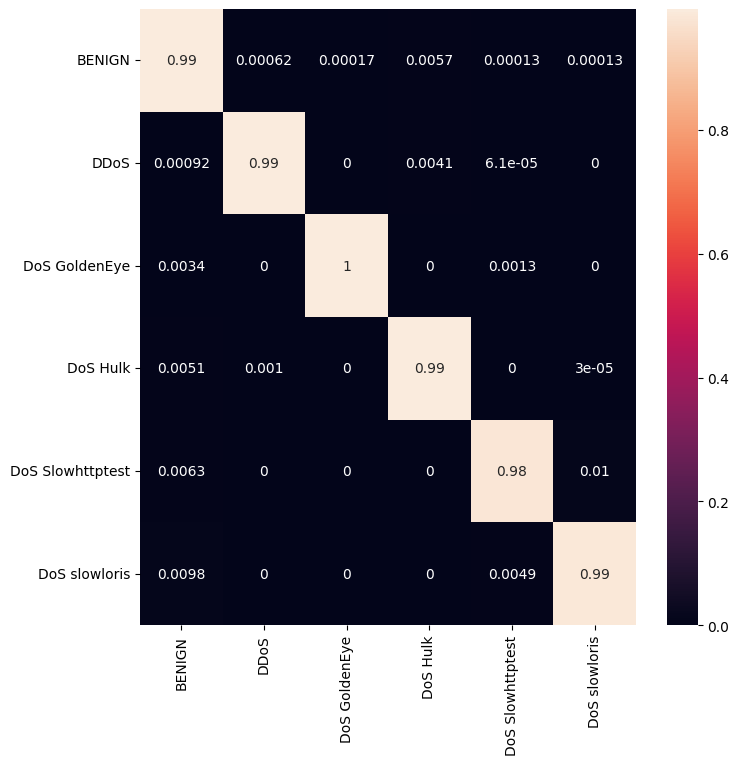

In [ ]:
# Generates confusion matrix
class_labels = [feature_mappings[mapping] for mapping in np.unique(y_test)]
cf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix / np.sum(cf_matrix, axis=1)[:, None], display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for KNN")
plt.show()